# Base Model

I have decided to go with a pre-trained model with adding custom layers on top for enhanced accuracy. The architecture used here is ResNet50 which is a 50 layer deep network. I considered using VGG16 as well but I am deciding to start with ResNet50 due to its greater depth and ability to generalize images well.

I am adding an additional dense layer followed by a dropout of 0.5 and l2 regularization set to 0.02 as default. Since we are predicting 2 targets, I decided to use a dense layer with softmax as activation for the 'Class' prediction, and sigmoid for 'MoreThanOnePerson'.

The optimizer used here is Adam as a start as it is quite optimal in capturing features in a large image dataset like ours.


---


For callbacks, I am using early stopping with a patience of 4 while monitoring the loss value for the validation set. I am also using a learning rate scheduler to reduce the learning rate slowly depending on the running epoch.

In [ ]:
import tensorflow as tf

def build_model(input_shape=(224, 224, 3), n_classes=40, learning_rate=0.001, dropout_rate=0.5, l2_reg=0.02):
    '''
    ResNet50-based model with dual outputs for activity classification and person detection.

    Args:
    - input_shape: Shape of the input images (height, width, channels)
    - n_classes: Number of activity classes
    - learning_rate: Initial learning rate for the optimizer
    - dropout_rate: Dropout rate for regularization
    - l2_reg: L2 regularization strength

    Returns:
    - model: Compiled Keras model
    '''

    # Define the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # load the base model ResNet50 model
    base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # set the last 10 layers to be trainable
    for layer in base.layers[-10:]:
        layer.trainable = True

    # Pass the inputs through the base model
    x = base(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Add dense layers with regularization and dropout
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layers for activity classification and person detection
    activity_output = tf.keras.layers.Dense(n_classes, activation='softmax', name='activity_output')(x)
    person_output = tf.keras.layers.Dense(1, activation='sigmoid', name='person_output')(x)

    # Create the model with two outputs
    model = tf.keras.Model(inputs=inputs, outputs=[activity_output, person_output])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss={'activity_output': 'categorical_crossentropy', 'person_output': 'binary_crossentropy'},
                  metrics={'activity_output': 'accuracy', 'person_output': 'accuracy'})

    return model

def get_callbacks(lr):
    '''
    Get a list of callbacks for training.

    Returns:
    - callbacks: List of Keras callbacks
    '''
    checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True, mode='min')

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    # Learning rate scheduler to reduce the learning rate with each epoch
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * 0.9 ** epoch)

    return [checkpoint, early_stopping, lr_schedule]

For the initial model, the learning rate I am using is 0.01 as it is a good point to start for this dataset. This is because of it being image classification

In [ ]:
lr = 1.0e-2  # Initial learning rate

# building the model
model_base = build_model(learning_rate=lr)

callbacks = get_callbacks(lr)

# training the model
history = model_base.fit(train_dataset,
                    validation_data=val_dataset,
                    batch_size=16, epochs=50,
                    callbacks=callbacks
                    )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 95s 196ms/step - activity_output_accuracy: 0.0385 - loss: 15.1780 - person_output_accuracy: 0.5965 - val_activity_output_accuracy: 0.0347 - val_loss: 9.8727 - val_person_output_accuracy: 0.6569 - learning_rate: 0.0100
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 31s 174ms/step - activity_output_accuracy: 0.0406 - loss: 4.3251 - person_output_accuracy: 0.6283 - val_activity_output_accuracy: 0.0375 - val_loss: 4.3836 - val_person_output_accuracy: 0.6569 - learning_rate: 0.0090
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - activity_output_accuracy: 0.0438 - loss: 4.3051 - person_output_accuracy: 0.6333 - val_activity_output_accuracy: 0.0389 - val_loss: 4.3137 - val_person_output_accuracy: 0.6569 - learning_rate: 0.0081
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 175ms/step - activity_output_accuracy: 0.0491 - loss: 4.3057 - person_output_accuracy: 0.6137 - val_activity_output_accuracy: 0.0389 

In [ ]:
predictions = model_base.predict(X_val) # make predictions on validation set

activity_predictions = predictions[0]
person_predictions = predictions[1]


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step


In [ ]:
# Evaluate the model on the validation dataset
eval_results = model_base.evaluate(val_dataset)

# Print evaluation results
print(f"Validation loss: {eval_results[0]}")
print(f"Validation activity accuracy: {eval_results[1]}")
print(f"Validation person accuracy: {eval_results[2]}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - activity_output_accuracy: 0.0681 - loss: 4.0692 - person_output_accuracy: 0.6377
Validation loss: 4.028773784637451
Validation activity accuracy: 0.07777778059244156
Validation person accuracy: 0.6569444537162781


Observations:


*   The Loss value is 4.02 which is quite high, indicating that there is room for improvements.
*   The accuracy for class prediction is 7.77% which seems very low. For the person accuracy, it still seems mediocre at about 65.69% but can be improved.
*   Let's take a look at the loss curve and accuracy comparisions between training and validation set.





**Loss**

Lets plot a graph to visualize the loss curve

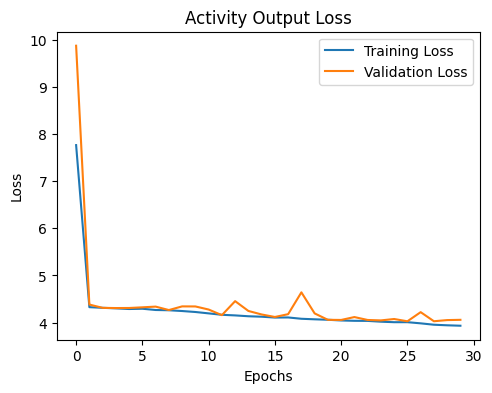

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss') # trining loss
plt.plot(history.history['val_loss'], label='Validation Loss') # validation loss
plt.title('Activity Output Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Observations:


*   The loss curve looks very rapid intially and then stabilizes a little bit at the end.
*   This suggests that either the model is not dense enough, or that the learning step is too high which is leading to loss of important features.



**Accuracy**

Lets now visualize the accuracies for both target variables.

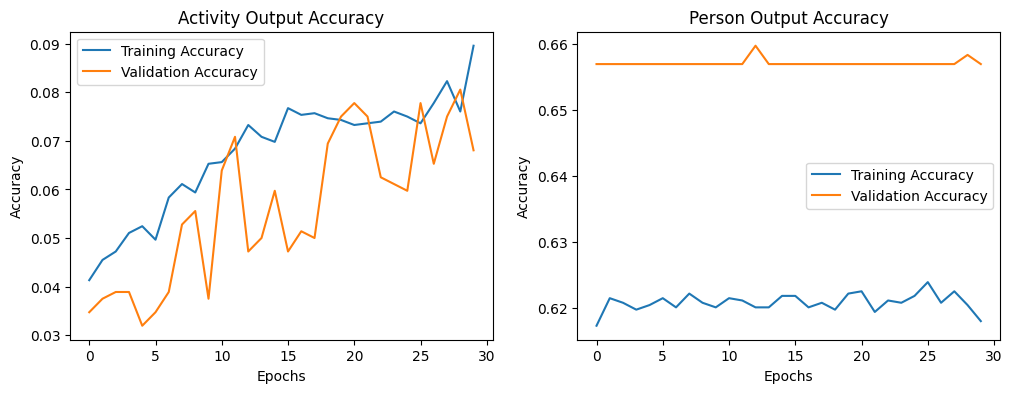

In [ ]:
# Plot the training and validation accuracy for activity output
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['activity_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_activity_output_accuracy'], label='Validation Accuracy')
plt.title('Activity Output Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation accuracy for person output
plt.subplot(1, 2, 2)
plt.plot(history.history['person_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_person_output_accuracy'], label='Validation Accuracy')
plt.title('Person Output Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Observations:


*   From the Activity Output Accuracy, we can say that the model is just not training well enough. This agin points towards 3 main possible reasons:


    1.   Insufficient data
    2.   Sub-optimal learning rate
    3.   Regularization


*   The training accuracy for activity shows that the model is learning gradually but is tuck at about 7-9% whereas the validation struggles between 6-8%. This means that the model is not generalising well on the validation data.
*   From the Person Output Accuracy, we can say that the model is training but is unable to learn anything from the data. This again points towards lack of generalisation.
* The model is also heavily overfitting due to the high number of epochs.

